<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/Fashion_MNIST_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [5]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#%%
# Define classic MLP architecture
def CNN_model(input_dim):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=input_dim ))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [7]:
#%%
# Initialize model
def init_model(input_dim):
    # svm = False
    # model = MLP_model(input_dim=Data_X.shape[1], svm_obj=svm)
    model = CNN_model(input_dim=input_dim)
    loss = tf.keras.losses.categorical_crossentropy
    metric = ['accuracy']
    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    return model

In [8]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [9]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    y_pred_soft = model.predict(X)
    y_pred_th = np.argmax(y_pred_soft, axis=1)
    return y_pred_soft, y_pred_th

In [10]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [11]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp):
      direction = 'further'
      # p_val = np.concatenate(y_val_pred_soft,axis=1)
      crit_val = entropy(y_val_pred_soft, axis=1, base=10)
      # p_test = np.concatenate(y_test_pred_soft,axis=1)
      crit_test = entropy(y_test_pred_soft, axis=1, base=10)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [12]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# y, y_test = y.astype('int8'), y_test.astype('int8')
# Rescale the images from [0,255] to the [0.0,1.0] range.
Data_X, X_test = Data_X[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(Data_X))
# reshape the data
# Data_X = Data_X.reshape(60000, 28*28).astype('float32')
# X_test = X_test.reshape(10000, 28*28).astype('float32')
# for keras classification, we need to use `to_categorical` to transform the label to appropriate format
Data_y = tf.keras.utils.to_categorical(Data_y)
y_test = tf.keras.utils.to_categorical(y_test)

4423680/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000


In [32]:
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=321)
clf = 'softmax_act'
addPredictions = True
applyPCA = True
accuracy = 0
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
for sample, test in kf.split(Data_X):
    sample = sample[:12500]
    test = test[:2000]
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1:])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val), callbacks=[es])

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    print('accuracy(Train)={}'.format(np.sum(y_train_pred_th==np.argmax(y_train,axis=1))/y_train_pred_th.size))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    if clf == 'softmax_act':
            activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[5].output)
            X_train_GP = activation_model.predict(X_train)
            X_val_GP = activation_model.predict(X_val)
            X_test_GP = activation_model.predict(X_test)
    elif clf == 'softmax':
            X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
            X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
            X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))

    # X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
    # X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
    # X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, np.argmax(y_train, axis=1), y_train_pred_th, \
                                   X_val_GP, np.argmax(y_val, axis=1), y_val_pred_th,\
                                   X_test_GP, np.argmax(y_test, axis=1), y_test_pred_th)
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(np.argmax(y_val, axis=1), y_val_pred_soft, y_val_pred_th,\
                                  np.argmax(y_test, axis=1), y_test_pred_soft, y_test_pred_th,\
                                  table, exp)
    report_criteria.append(crit_table)

    score = np.sum(np.argmax(y_val, axis=1)==y_val_pred_th)/np.size(np.argmax(y_val, axis=1))
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    del(model)

Epoch 00007: early stopping
accuracy(Train)=0.9171
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.026  noise: 0.028
Iter 492/500 - Loss: -0.027  noise: 0.028
Iter 493/500 - Loss: -0.027  noise: 0.028
Iter 494/500 - Loss: -0.028  noise: 0.028
Iter 495/500 - Loss: -0.029  noise: 0.028
Iter 496/500 - Loss: -0.027  noise: 0.028
Iter 497/500 - Loss: -0.029  noise: 0.028
Iter 498/500 - Loss: -0.029  noise: 0.028
Iter 499/500 - Loss: -0.029  noise: 0.028
Iter 500/500 - Loss: -0.028  noise: 0.028
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
5
accuracy(Train)=0.9303
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.096  noise: 0.025
Iter 492/500 - Loss: -0.095  noise: 0.025
Iter 493/500 - Loss: -0.094  noise: 0.025
Iter 494/500 - Loss: -0.096  noise: 0.025
Iter 495/500 - Loss: -0.096  noise: 0.025
Iter 496/500 - Loss: -0.095  noise: 0.025
Iter 497/500 - Loss: -0.094  noise: 0.025
Iter 498/500 - Loss: -0.095  noise: 

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [33]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [34]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [35]:
# Dataframe for results f(x)
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 6.4(6.3-6.5) & 0.01(0.01-0.01) & 6.2(6.2-6.7) & $\surd$ \\
{} & {} & 0.05 & 24.0(23.7-26.8) & 0.05(0.05-0.05) & 25.0(24.9-27.0) & $\surd$ \\
{} & {} & 0.10 & 44.0(43.8-44.3) & 0.10(0.10-0.12) & 44.2(42.2-47.5) & $\surd$ \\
{} & {} & 0.15 & 60.0(59.0-60.8) & 0.15(0.15-0.16) & 60.0(58.2-60.0) & $\surd$ \\
{} & {} & 0.20 & 74.3(71.0-74.7) & 0.20(0.20-0.21) & 70.9(70.2-73.3) & $\surd$ \\



In [36]:
# Dataframe for comparison f(x)-g(x)
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 6.2(6.2-6.7) & 6.0(5.3-6.7) & 0.98(0.98-0.98) & $\surd$ \\
{} & {} & 0.05 & 25.0(24.9-27.0) & 23.3(22.2-24.7) & 0.93(0.93-0.94) & $\surd$ \\
{} & {} & 0.10 & 44.2(42.2-47.5) & 41.7(41.2-41.8) & 0.91(0.90-0.91) & $\surd$ \\
{} & {} & 0.15 & 60.0(58.2-60.0) & 58.2(57.8-60.4) & 0.90(0.89-0.90) & $\surd$ \\
{} & {} & 0.20 & 70.9(70.2-73.3) & 68.9(68.3-70.4) & 0.89(0.89-0.89) & $\surd$ \\



In [37]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/fashionMNIST/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx], keys=['fx', 'fxgx'], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/fashionMNIST/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

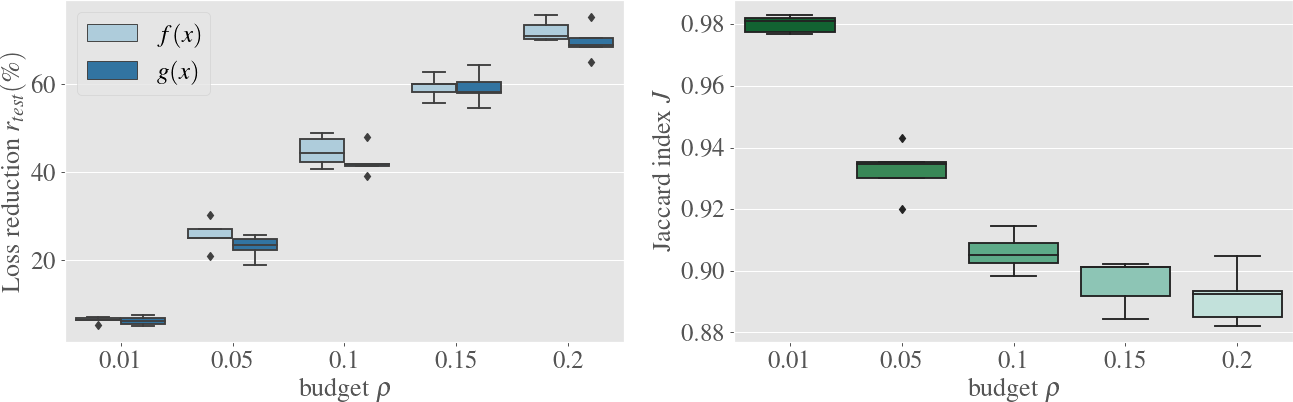

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/fashionMNIST/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [39]:
rho = 0.01
X_test_best = X_test_best.squeeze()
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 8 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
# p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
crit_test = entropy(y_test_pred_soft_best, axis=1, base=10)
top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
output_text = io.StringIO()
print('eta={},theta={}'.format(eta,theta))

eta=0.541553795337677,theta=0.6209297776222229


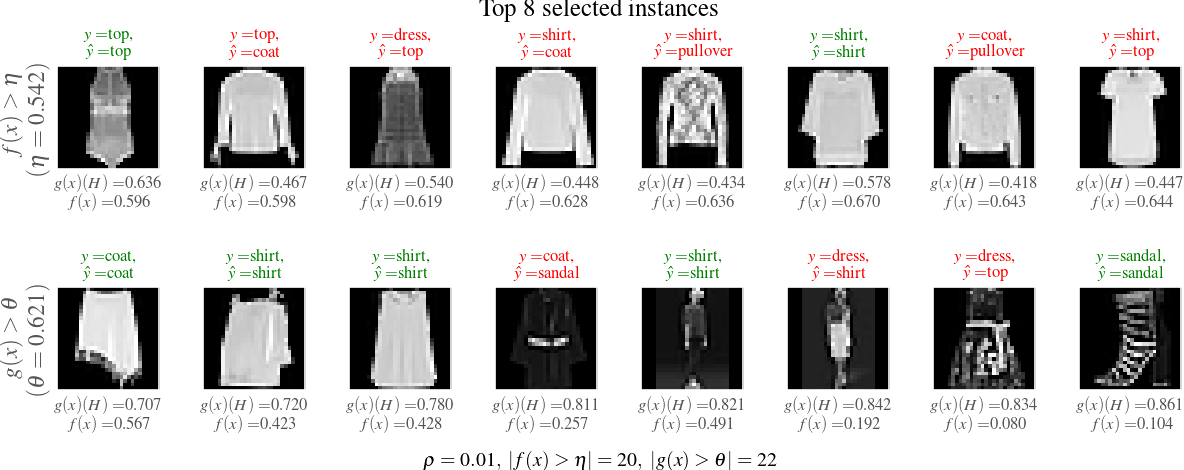

In [40]:
# Plot selected instances
# initialize the label 
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# X_test_best = X_test.reshape(-1,28,28)
# y_hat_best = y_test_pred_th[top_f_idx]
# y_th_best = np.argmax(y_test[top_f_idx], axis=1)
# Plot instances
row,col = 2,8
fig1, ax = plt.subplots(row, col, figsize=(10.4, 4.0), constrained_layout=False, dpi=120)
fig1.subplots_adjust(wspace=0.1, hspace=0.35, top=0.5)
# for i in top_f_idx:
j = 0
for i,k in zip(top_f_idx, top_crit_idx):
    if np.argmax(y_test_best, axis=1)[i] != y_test_pred_th_best[i]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[0][j].imshow(X_test_best[i, :, :], cmap='gray', interpolation='none')
    ax[0][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[i]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[i]]), color=color, fontsize=10)
    ax[0][j].set_xlabel(r"$g(x)(H)=${:.3f}".format(crit_test[i])+'\n$f(x)=${:.3f}'.format(f_test[i]), fontsize=10)
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    if np.argmax(y_test_best, axis=1)[k] != y_test_pred_th_best[k]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[1][j].imshow(X_test_best[k, :, :], cmap='gray', interpolation='none')
    ax[1][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[k]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[k]]), color=color, fontsize=10)
    ax[1][j].set_xlabel(r"$g(x)(H)=${:.3f}".format(crit_test[k])+'\n$f(x)=${:.3f}'.format(f_test[k]), fontsize=10)
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])
    j = j + 1
ax[0][0].set_ylabel(r"$f(x)>\eta$"+"\n"+r"$(\eta={:.3f})$".format(eta), fontsize=14)
ax[1][0].set_ylabel(r"$g(x)>\theta$"+"\n"+r"$(\theta={:.3f})$".format(theta), fontsize=14)
fig1.text(0.5, 0.01, r'$\rho={},~|f(x)>\eta|={},~|g(x)>\theta|={}$'.format(rho,np.sum(f_test>eta),np.sum(crit_test>theta)), ha='center', fontsize = 12)
plt.suptitle(r'Top {} selected instances'.format(top_n), fontsize=15)
plt.tight_layout()
path_fig_fx_test = "drive/My Drive/NIPS2020/results/fashionMNIST/fig_fxgx_test_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx_test, bbox_inches='tight', facecolor='w')

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()

In [ ]:
report_table_mean

In [ ]:
report_criteria_mean

In [ ]:
report_table_std

In [ ]:
report_criteria_std